In [58]:
import numpy as np
import pandas as pd
import pystan
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from src.stan_data_format import format_stan_data_logistic
from src.utils import pickle_model, load_model, make_latex_table, save_latex_table
from src.clean import clean_exp_2, clean_exp_1, clean_exp3
print(pystan.__version__)

%matplotlib inline
%load_extautoreload
%autoreload 2

2.19.1.1


UsageError: Line magic function `%load_extautoreload` not found.


In [59]:
import os
os.environ['STAN_NUM_THREADS'] = "20"



In [60]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

<H1>Preprocessing</H1> 


In [ ]:
# File locations
EXPERIMENT_1 = './dat/raw/Experiment1.csv'
EXPERIMENT_2 = './dat/raw/Experiment2.csv'
EXPERIMENT_2 = './dat/raw/Experiment3.csv'

# Output locations
FIGURE_OUTPUT = './out/figures/'
CHAIN_OUTPUT = './out/chains/'
MODEL_OUTPUT = './out/models/'


TABLE_OUTPUT = './out/tables/'
CLEAN_DATA_EXP1 = './dat/cleaned/clean_exp1.csv'
CLEAN_DATA_EXP2 = './dat/cleaned/clean_exp2.csv'

SIMULATION_DATA = './dat/cleaned/simulation.csv'

# Utility function for inv_logit


def ilogit(x):
    return 1/(1+np.exp(-x))

In [10]:
# Clean and save data.
clean_exp1_df = clean_exp_1(pd.read_csv(EXPERIMENT_1))
clean_exp1_df.to_csv(CLEAN_DATA_EXP1)

/home/joseph/github/polarized-collective-wisdom/src/clean.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data['difficulty'] = [difficulty[item] for item in true_data.states.values]
/home/joseph/github/polarized-collective-wisdom/src/clean.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['difficulty'] = [difficulty[item] for item in false_data.states.values]


In [6]:
# Clean and save data.
import os
pd.read_csv('./dat/raw/Experiment2.csv')
clean_exp2_df = clean_exp_2(pd.read_csv(EXPERIMENT_2, skiprows=[1, 2]))
clean_exp2_df.to_csv(CLEAN_DATA_EXP2)

<h2>Extract demographic information for experiments 1, 2</h3>

<ipython-input-7-599431eb30a7>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Exp1_demographics.pdf', fmt='pdf')
<ipython-input-7-599431eb30a7>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Exp2_demographics.pdf', fmt='pdf')


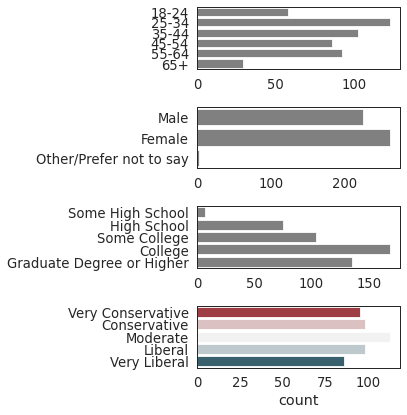

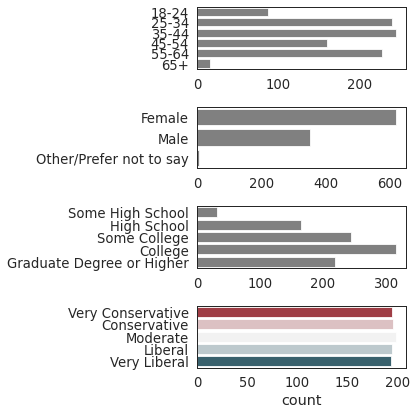

In [7]:
from src.demographics import demographics_exp_1, demographics_exp_2
# Plot demographic figures for SI
plt.figure(figsize=(6, 6))
dem1 = demographics_exp_1(pd.read_csv(EXPERIMENT_1))
plt.savefig(FIGURE_OUTPUT+'Exp1_demographics.pdf', fmt='pdf')
plt.figure(figsize=(6, 6))
dem2 = demographics_exp_2(pd.read_csv(CLEAN_DATA_EXP2))
plt.savefig(FIGURE_OUTPUT+'Exp2_demographics.pdf', fmt='pdf')

<h1>Experiment 1 Analysis</h1>

<h2>Convidence vs. Accuracy</h3> 

In [7]:
model_confidence_accuracy_logit = pystan.StanModel(
    file='./src/confidence_accuracy_logit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3427a9a7c8850d25368b67c8c12231fc NOW.


<h3>Prior Predictive Check</h3>

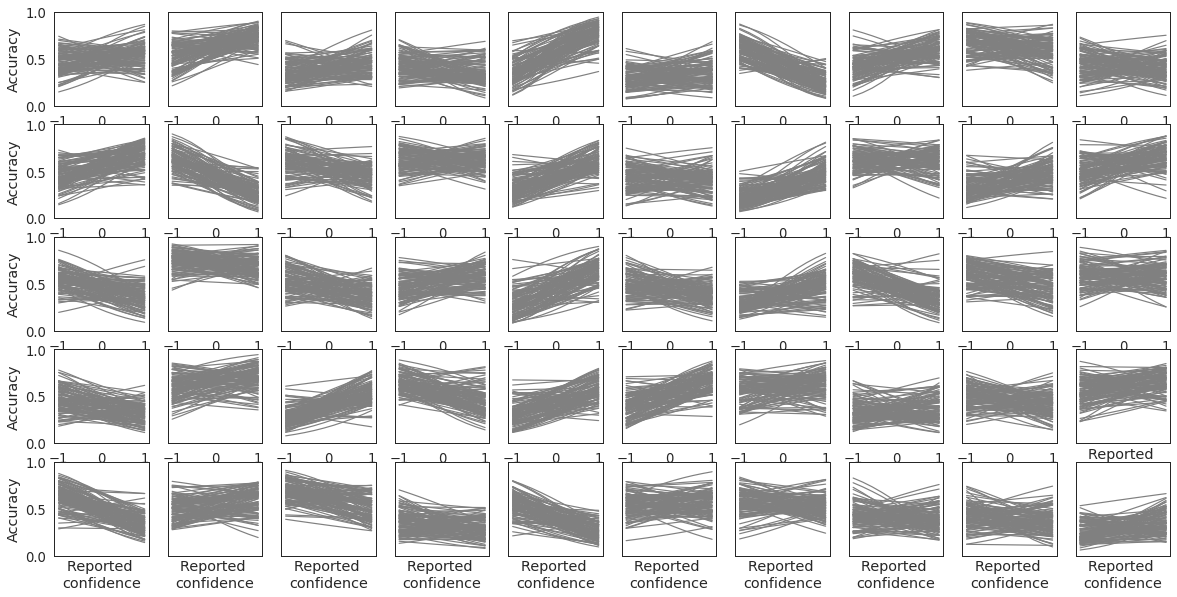

In [8]:
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
def plot_figure1b_prior(stan_data_logistic):
    x = np.linspace(np.min(stan_data_logistic['x']),np.max(stan_data_logistic['x']),10)
    plt.figure(figsize=(20, 10))
    for kdx in range(10):
        for idx in range(5):
            plot_no = idx+1 + 5 * kdx
            plt.subplot(5,10,plot_no)
            alpha_p = np.random.normal(0,.4, 1)
            beta_p = np.random.normal(0,.4, 1)
            alpha = np.random.normal(alpha_p, .4, 100)
            beta = np.random.normal(beta_p, .4, 100)
            y = np.array([alpha + beta * item for item in  x])
            y = ilogit(y)
            plt.plot(x,y, color='grey')
            #plt.ylim(.2,.8)
            #plt.xlim(50,100)
            
            if plot_no%10 == 1:
                plt.ylabel('Accuracy')
            else:
                plt.yticks([])
            if plot_no >= 40:
                plt.xlabel('Reported \nconfidence')
                plt.xticks([])
            plt.ylim(0,1)

plot_figure1b_prior(stan_data_logistic)

<h3>Sample and evaluate MCMC</h3>

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

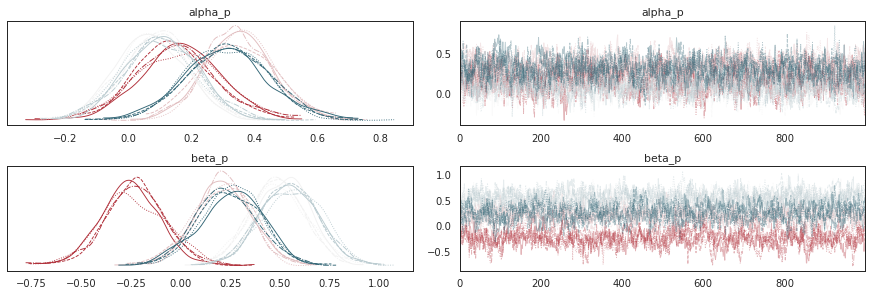

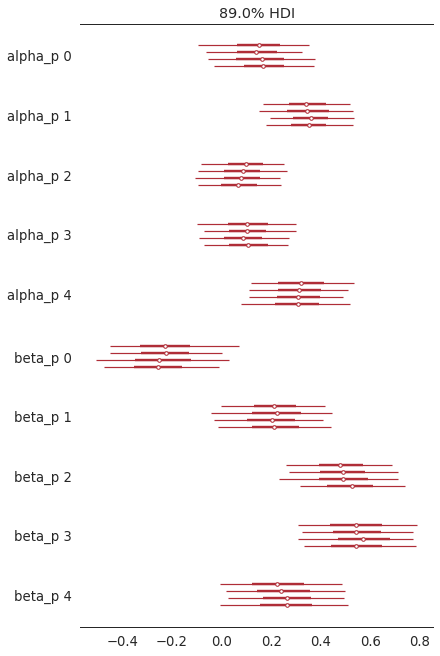

In [12]:
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
# MCMC  Time
samples_logistic = model_confidence_accuracy_logit.sampling(
    data=stan_data_logistic)

# Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
# Save model and output for easy loading later.
pickle_model(model_confidence_accuracy_logit,
             samples_logistic,
             MODEL_OUTPUT,
             CHAIN_OUTPUT,
             'confidence_accuracy_logit')
# Plot chains
#samples_logistic.plot(pars=['alpha_p', 'beta_p'])
az.plot_trace(samples_logistic,
              var_names=['alpha_p', 'beta_p'])
az.plot_forest(samples_logistic, var_names=[
               'alpha_p', 'beta_p'], credible_interval=.89)

In [13]:

model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT,
                                                               'confidence_accuracy_logit')

<h3>Figure and Table output</h3>

In [14]:
# Save key output as a LaTeX file.
variables = ['alpha_p', 'beta_p']
extracted_samples_logistic['beta_p']
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_accuracy_logit.tex', latex_string)

\begin{tabular}{lrrrrr}
\toprule
variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_p &  0.155542 &  0.130985 & -0.050077 &  0.155412 &  0.374011 \\
 alpha\_p &  0.352434 &  0.110508 &  0.177792 &  0.349496 &  0.536144 \\
 alpha\_p &  0.082513 &  0.109629 & -0.091768 &  0.083308 &  0.256323 \\
 alpha\_p &  0.100980 &  0.115210 & -0.086609 &  0.099451 &  0.284163 \\
 alpha\_p &  0.312772 &  0.129020 &  0.105955 &  0.311557 &  0.517149 \\
  beta\_p & -0.238404 &  0.157737 & -0.486939 & -0.239725 &  0.013162 \\
  beta\_p &  0.211388 &  0.143653 & -0.025969 &  0.213290 &  0.431916 \\
  beta\_p &  0.494236 &  0.139073 &  0.268959 &  0.494236 &  0.718201 \\
  beta\_p &  0.551768 &  0.146765 &  0.320962 &  0.550998 &  0.787179 \\
  beta\_p &  0.248280 &  0.155634 & -0.004252 &  0.249366 &  0.492080 \\
\bottomrule
\end{tabular}



In [15]:
from src.exp_1_figures import plot_figure1a
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plt.savefig(FIGURE_OUTPUT+'joint_hpdi.pdf', fmt='pdf')

<ipython-input-15-5a5c1ba4c955>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'joint_hpdi.pdf', fmt='pdf')


<Figure size 432x288 with 0 Axes>

/home/joseph/github/polarized-collective-wisdom/src/exp_1_figures.py:49: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(xi, yi, zi,levels = levels,
/home/joseph/github/polarized-collective-wisdom/src/exp_1_figures.py:49: UserWarning: The following kwargs were not used by contour: 'shade'
  CS = plt.contourf(xi, yi, zi,levels = levels,


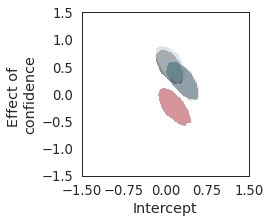

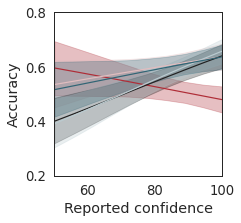

In [16]:
from src.exp_1_figures import joint_hpdi

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
joint_hpdi(extracted_samples_logistic)


from src.exp_1_figures import plot_figure1b

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
plot_figure1b(extracted_samples_logistic, stan_data_logistic)



<h3>Accuracy by Political Leaning</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

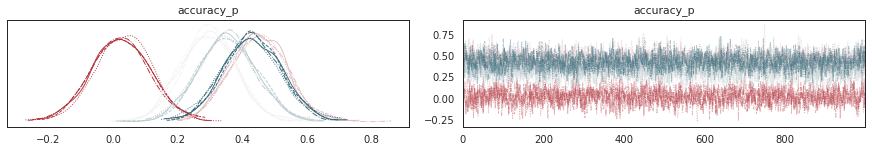

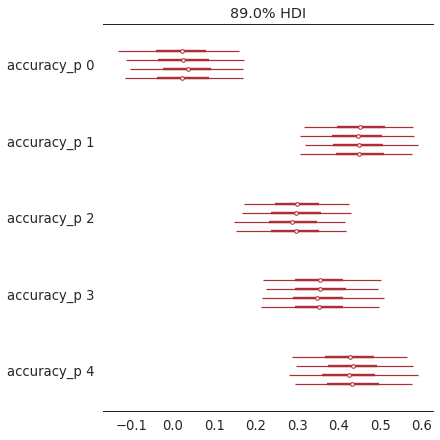

In [17]:
az.plot_trace(samples_logistic, var_names=['accuracy_p'])
az.plot_forest(samples_logistic, var_names=['accuracy_p'],
               credible_interval=.89)

In [18]:
extracted_samples_logistic = samples_logistic.extract(['accuracy_p'])
variables = ['accuracy_p']
extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'accuracy.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
   variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 accuracy\_p &  0.506526 &  0.022320 &  0.470422 &  0.506380 &  0.541972 \\
 accuracy\_p &  0.610140 &  0.020636 &  0.577488 &  0.610297 &  0.642770 \\
 accuracy\_p &  0.573072 &  0.020462 &  0.540944 &  0.573333 &  0.605384 \\
 accuracy\_p &  0.587301 &  0.021514 &  0.552722 &  0.587194 &  0.621817 \\
 accuracy\_p &  0.605460 &  0.021459 &  0.570873 &  0.605460 &  0.640178 \\
\bottomrule
\end{tabular}



<h2>Agent model of confidence</h2>

<h3>Prior Predictitive Checks</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


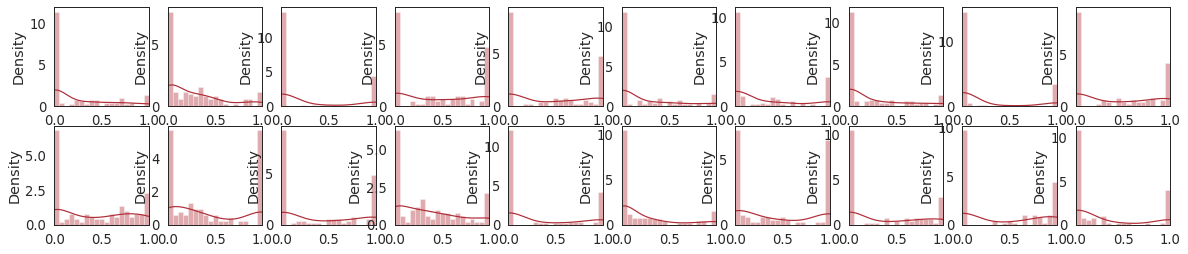

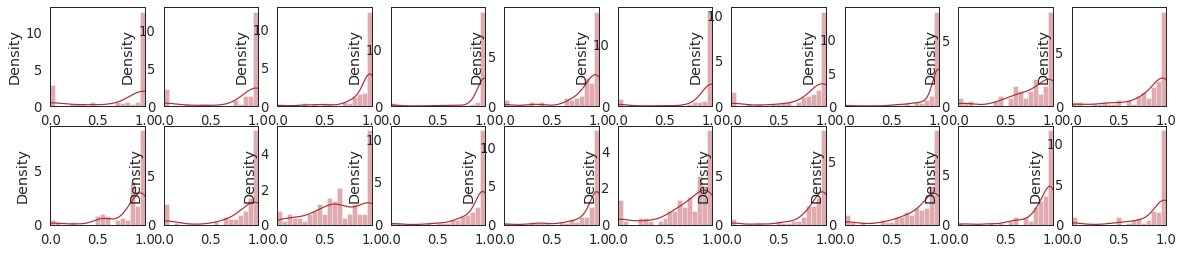

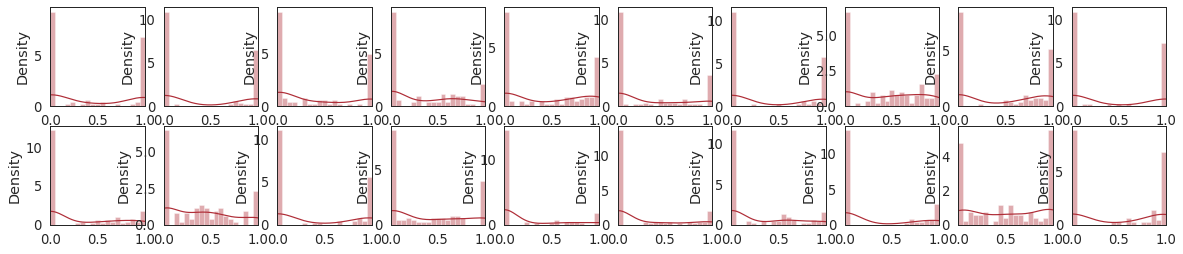

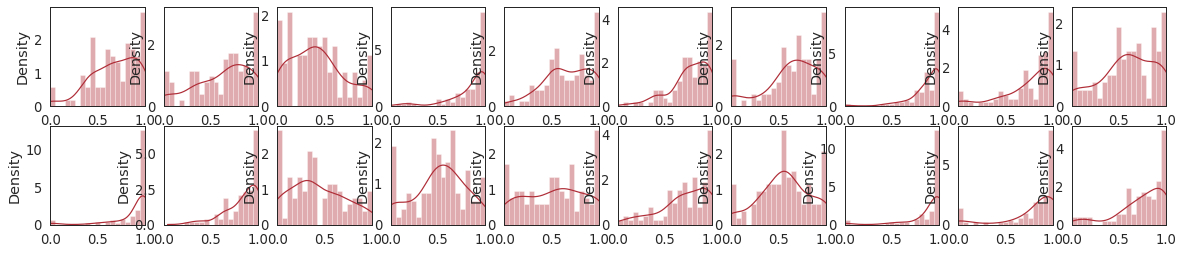

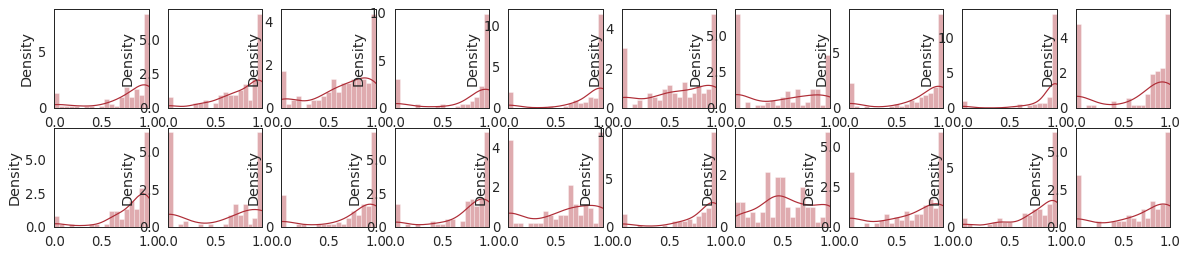

In [19]:
#Simulate different political groups
correct = 1 #Change to zero to simulate when incorrect

for p in range(5):
    plt.figure(figsize=(20,4))
    mu_a_pol  = np.random.normal(0,1)
    alpha_a_pol =  np.random.normal(-1,1)
    gamma_a_pol =  np.random.normal(0,1)

    mu_b_pol  =  np.random.normal(0,.5)
    alpha_b_pol =  np.random.normal(0,.5)
    gamma_b_pol =  np.random.normal(0,.5)
    #And Individuals
    for k in range(20):



        mu_a = np.random.normal(mu_a_pol,.5)
        alpha_a = np.random.normal(alpha_a_pol,.5)
        gamma_a = np.random.normal(gamma_a_pol,.5)

        mu_b  = np.random.normal(mu_b_pol,.5)
        alpha_b = np.random.normal(alpha_b_pol,.5)
        gamma_b = np.random.normal(gamma_b_pol,.5)


        mu = np.zeros(100)
        alpha = np.zeros(100)
        gamma = np.zeros(100)
        y_sim = np.zeros(100)


        plt.subplot(2,10,k+1)
        for i in range(100):
            theta = abs(np.random.normal(0,5));
            mu[i] = ilogit(mu_a + mu_b*correct);
            alpha[i] = ilogit(alpha_a + alpha_b*correct);
            gamma[i] = ilogit(gamma_a + gamma_b*correct);

            if np.random.binomial(1, alpha[i])==1:
                if np.random.binomial(1, gamma[i]) == 1:
                    y_sim[i] = 1
                else:
                    y_sim[i] = 0
            else: 
                y_sim[i] = np.random.beta(mu[i]*theta, (1-mu[i])*theta)

        sns.distplot(y_sim,bins=np.linspace(0,1,20))
        plt.xlim(0,1)
    

<h3>Model compiliation and Sampling</h3>


In [20]:
belief_model = pystan.StanModel(file='./src/belief_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e5b3cb09920a7f1c37ee7574bf7946a NOW.


In [21]:
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
from src.stan_data_format import format_stan_data_belief
stan_data = format_stan_data_belief(exp_1_data)
belief_samples = belief_model.sampling(data = stan_data)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
pickle_model(belief_model, 
             belief_samples, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'belief')

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


<h3>Evaluate MCMC</h3>

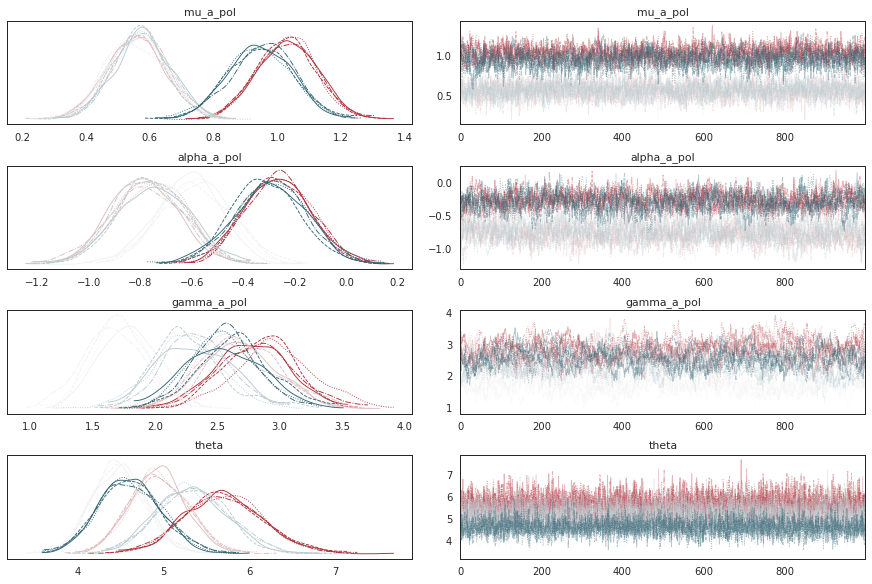

In [23]:
az.plot_trace(belief_samples, 
              var_names=['mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol',
                        'theta']);

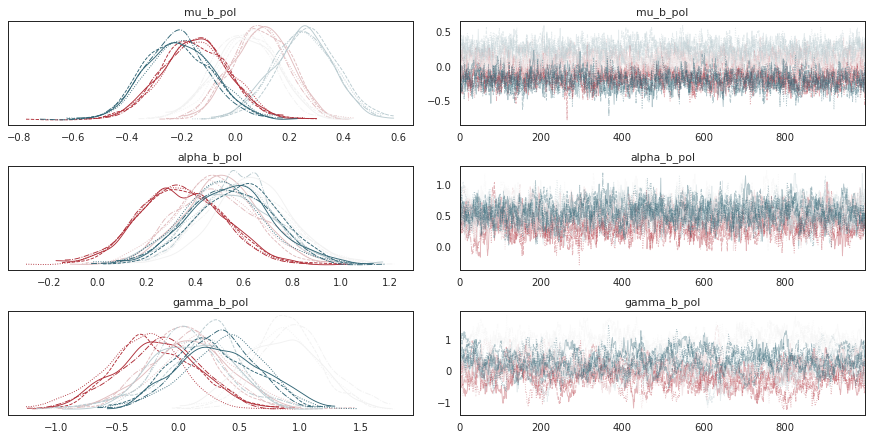

In [24]:
az.plot_trace(belief_samples, 
              var_names=['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol']);

In [25]:
extracted_belief_samples = belief_samples.extract(['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol','mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol','theta'])
variables = ['alpha_a_pol', 'gamma_a_pol', 'mu_a_pol', 
             'alpha_b_pol', 'gamma_b_pol', 'mu_b_pol','theta' ]
# extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_belief_samples, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_agent.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_a\_pol & -0.266965 &  0.127271 & -0.467965 & -0.267008 & -0.064690 \\
 alpha\_a\_pol & -0.771869 &  0.135978 & -0.990699 & -0.770555 & -0.562703 \\
 alpha\_a\_pol & -0.593683 &  0.134030 & -0.809727 & -0.593034 & -0.382716 \\
 alpha\_a\_pol & -0.762800 &  0.135208 & -0.977168 & -0.764182 & -0.548012 \\
 alpha\_a\_pol & -0.294766 &  0.138577 & -0.517077 & -0.296832 & -0.073551 \\
 gamma\_a\_pol &  2.844304 &  0.312597 &  2.347879 &  2.850356 &  3.359459 \\
 gamma\_a\_pol &  2.662762 &  0.311586 &  2.193439 &  2.640499 &  3.191258 \\
 gamma\_a\_pol &  1.725662 &  0.233590 &  1.366370 &  1.719559 &  2.113274 \\
 gamma\_a\_pol &  2.294279 &  0.287138 &  1.857882 &  2.282400 &  2.770997 \\
 gamma\_a\_pol &  2.575988 &  0.285947 &  2.122760 &  2.568327 &  3.050785 \\
    mu\_a\_pol &  1.029115 &  0.093503 &  0.877613 &  1.030136 &  1.176113 \\
    mu\_a\_pol &  0.5

<h3>Posterior Predictive</h3>

In [26]:
#Some of those chains look a bit autocorrelated but converged, so let's look at the ppd. 

belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                           CHAIN_OUTPUT, 
                                        'belief')

belief_samps = belief_samples.extract()


/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)
<ipython-input-27-1d7a6d463db4>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3

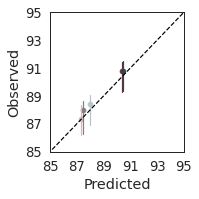

In [27]:
from src.posterior_predictive import plot_predicted_vs_observed_belief_model
#plt.savefig('../Graphs/PredictedVsObserved.pdf', fmt='.pdf',dpi=1500)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)

sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(3,3))
plot_predicted_vs_observed_belief_model(belief_samps, exp_1_data);
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedBelief.pdf', fmt='pdf')


/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)
<ipython-input-28-fa42905c8b3c>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3

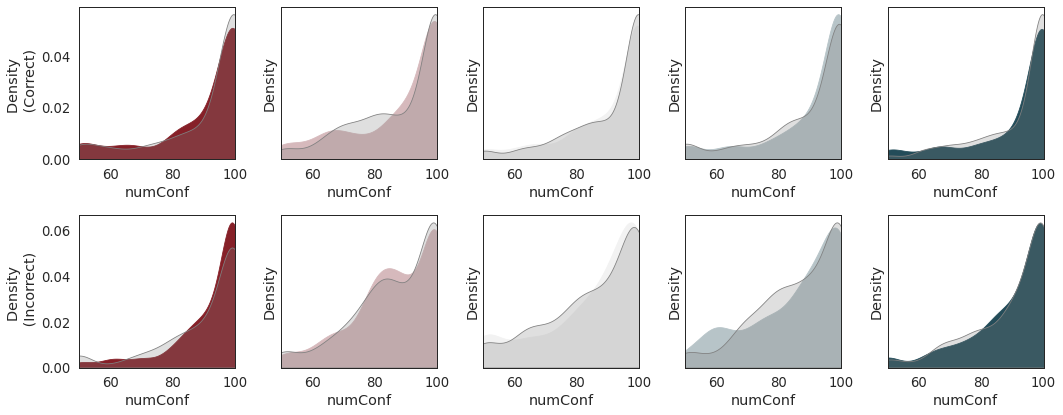

In [28]:
from src.posterior_predictive import plot_belief_model_distributions

exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
sns.set_context()
plt.figure(figsize=(15,6))
plot_belief_model_distributions(exp_1_data,belief_samps)
plt.savefig(FIGURE_OUTPUT+'PosteriorPredictiveConfidenceDistributions.pdf', fmt='pdf')



<h2>Agent model of social influence</h2>

<h3>Model for Initially Correct Participants</h3>

<h4>Compile and Sample</h4>

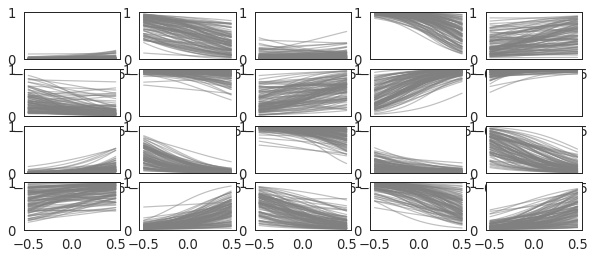

In [29]:
plt.figure(figsize=(10, 4))
for idx in range(20):
    plt.subplot(4,5,idx+1)
    alpha_p = np.random.normal(0,2);
    b_conf_p = np.random.normal(0,2);
    b_socConf_p = np.random.normal(0,2);

    alpha = np.random.normal(alpha_p, 1, 100);
    b_conf = np.random.normal(b_conf_p, 1, 100);

    x = np.linspace(-.5,.5, 100)
    y_sim = np.array([alpha + b_conf * item for item in x])
    plt.plot(x,ilogit(y_sim),color='grey',alpha=.5)
    plt.ylim(0,1)

In [30]:
switch_model = pystan.StanModel(file='./src/switch_model.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68dd4818b050fd456b35236fb514ed4e NOW.


In [31]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_correct, _= format_stan_data_switch(exp_1_data,correct=True)

switch_samples_correct = switch_model.sampling(data=stan_model_data_correct)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4>Evaluate MCMC</h4>

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


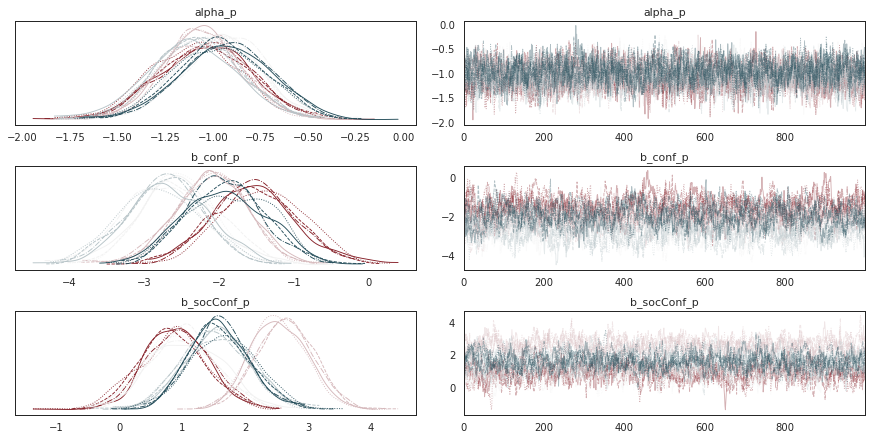

In [32]:
import arviz as av
#Extract samples
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_correct, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_correct');

#Plot chains
av.plot_trace(switch_samples_correct, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Text(0.5, 1.0, 'Initially \ncorrect')

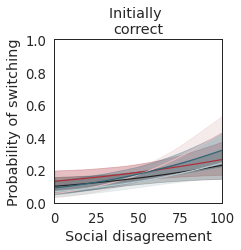

In [33]:
from src.exp_1_figures import plot_fig1cd

stan_model_data_correct, df= format_stan_data_switch(exp_1_data,correct=True)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)

plt.title('Initially \ncorrect')




In [34]:
#Make table 
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_correct, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_correct.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -1.056880 &  0.243637 & -1.440203 & -1.051426 & -0.675604 \\
     alpha\_p & -1.056555 &  0.208180 & -1.382240 & -1.057253 & -0.725204 \\
     alpha\_p & -0.966151 &  0.217892 & -1.318248 & -0.959858 & -0.627579 \\
     alpha\_p & -1.088859 &  0.226364 & -1.450211 & -1.088496 & -0.723309 \\
     alpha\_p & -0.947433 &  0.236279 & -1.321249 & -0.947339 & -0.571093 \\
    b\_conf\_p & -1.506457 &  0.559429 & -2.392278 & -1.514037 & -0.597006 \\
    b\_conf\_p & -2.090057 &  0.478612 & -2.873206 & -2.082064 & -1.357591 \\
    b\_conf\_p & -2.595094 &  0.533018 & -3.435595 & -2.601965 & -1.721281 \\
    b\_conf\_p & -2.729334 &  0.526985 & -3.583519 & -2.726992 & -1.882569 \\
    b\_conf\_p & -1.907784 &  0.536130 & -2.759340 & -1.921622 & -1.058317 \\
 b\_socConf\_p &  0.885118 &  0.525261 &  0.049107 &  0.886437 &  1.730324 \\
 b\_socConf\_p &  2.578646

<h3>Model for Initially Incorrect particpants</h3>

<h4>Compile and Sample</h4>

In [35]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)

switch_samples_incorrect = switch_model.sampling(data=stan_model_data_incorrect)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4> Evaluate MCMC </h4>

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


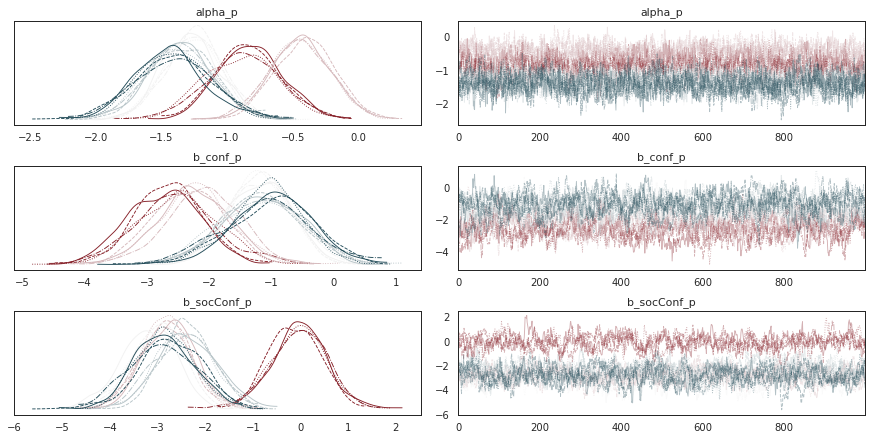

In [36]:
import arviz as av
#Extract samples
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_incorrect, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_incorrect');
#Plot chains
av.plot_trace(switch_samples_incorrect, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Text(0.5, 1.0, 'Initially \nincorrect')

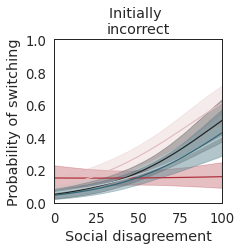

In [37]:
from src.exp_1_figures import plot_fig1cd

stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')




In [38]:
#Make table
from src.utils import make_latex_table
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_incorrect, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_incorrect.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -0.860112 &  0.266816 & -1.283508 & -0.859104 & -0.431191 \\
     alpha\_p & -0.436471 &  0.229855 & -0.805553 & -0.435579 & -0.070883 \\
     alpha\_p & -1.264189 &  0.221688 & -1.616244 & -1.261072 & -0.914501 \\
     alpha\_p & -1.358588 &  0.248622 & -1.750800 & -1.361697 & -0.966503 \\
     alpha\_p & -1.415023 &  0.283204 & -1.860864 & -1.415287 & -0.958437 \\
    b\_conf\_p & -2.601139 &  0.618805 & -3.571468 & -2.595097 & -1.587430 \\
    b\_conf\_p & -2.222842 &  0.593422 & -3.189968 & -2.218834 & -1.291822 \\
    b\_conf\_p & -1.178405 &  0.494090 & -1.958033 & -1.176439 & -0.393838 \\
    b\_conf\_p & -1.164089 &  0.646002 & -2.216903 & -1.161856 & -0.136821 \\
    b\_conf\_p & -1.037570 &  0.658142 & -2.137726 & -1.009742 & -0.007041 \\
 b\_socConf\_p & -0.053588 &  0.585631 & -0.995270 & -0.044984 &  0.850850 \\
 b\_socConf\_p & -2.799610

<h3> Posterior Preditive Checks</h3>

<ipython-input-39-eaa9840926ff>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedSwitch.pdf', fmt='pdf')


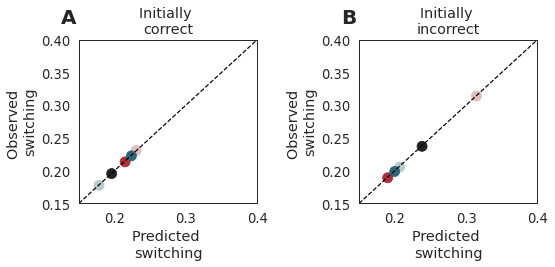

In [39]:
from src.exp_1_figures import plot_switch_predicted_acuracy
plt.figure(figsize=(8,4))
plt.subplot(121)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=True)
plot_switch_predicted_acuracy(df, switch_samples_correct, correct=True)
plt.title('Initially \ncorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.subplot(122)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)
plot_switch_predicted_acuracy(df, switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedSwitch.pdf', fmt='pdf')


<h2>Figure 1</h2>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


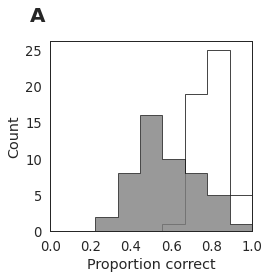

In [155]:
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-156-ce92de9144e0>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure1.pdf', fmt='pdf')


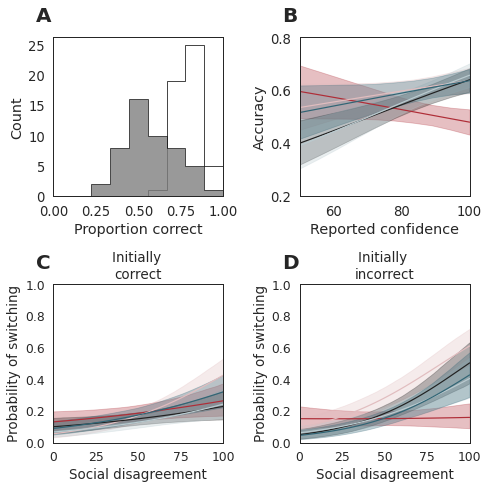

In [156]:
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()


plt.subplot(222)
sns.set_context('paper', font_scale=1.4)
model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT, 
                                                            'confidence_accuracy_logit')
#Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
#Get the data in the format the model wants to see it. 
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
plot_figure1b(extracted_samples_logistic, stan_data_logistic)
ax=plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(223)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=True)
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)
plt.title('Initially \ncorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(224)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect,correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.savefig(FIGURE_OUTPUT+'Figure1.pdf', fmt='pdf')


<h1> Simulation Study</h1>

<h2>Load Models</h2>

In [6]:
switch_samples_correct_model, switch_samples_correct = load_model(MODEL_OUTPUT,
                                                                  CHAIN_OUTPUT,
                                                                  'switch_samples_correct')
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p',
                                                                   'b_conf_p',
                                                                   'b_socConf_p'])


switch_samples_incorrect_model, switch_samples_incorrect = load_model(MODEL_OUTPUT,
                                                                      CHAIN_OUTPUT,
                                                                      'switch_samples_incorrect')
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p',
                                                                       'b_conf_p',
                                                                       'b_socConf_p'])


belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                          CHAIN_OUTPUT,
                                          'belief')

extracted_belief_samples = belief_samples.extract()

NameError: name 'MODEL_OUTPUT' is not defined

<h2>Simulate</h2>

In [103]:
from pandarallel import pandarallel
import itertools as it
from src.simulation_study import run_single
from tqdm.auto import tqdm
from multiprocessing import cpu_count

tqdm.pandas(desc="my bar!")

pandarallel.initialize(nb_workers=cpu_count(), progress_bar=True)


dat_dict ={'proportions':[[75,50,30,50,75]],
             'p':[.5,.75,.98],
             'diff':np.linspace(.40,.6,20),
             'repeat':np.arange(2000),
             'N':[500],
             'lean':np.array(['right','left',False])}

def get_combinations_dataframe(dd):
    allNames = sorted(dd)
    combinations = it.product(*(dd[Name] for Name in allNames))
    dat = pd.DataFrame(list(combinations), columns=allNames)
    return(dat)

df = get_combinations_dataframe(dat_dict)
    
run_row = lambda dat : run_single(dat['p'],
            dat['diff'],
            dat['N'],
            dat['proportions'],
            dat['lean'],
            extracted_belief_samples,
            extracted_switch_samples_incorrect,
            extracted_switch_samples_correct)

%time simulation_results = df.parallel_apply(run_row, axis=1)



/home/joseph/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


CPU times: user 1min 19s, sys: 7.67 s, total: 1min 26s
Wall time: 6min 20s


<h3>Store Data</h3>

In [104]:
# df['correct_final'] = np.array(np.hstack(simulation_results))
sim_results = np.vstack(simulation_results)
df['correct_final'] = sim_results[:,0]
df['correct_start'] = sim_results[:,0]
df.to_csv(SIMULATION_DATA)



<h3>Load Data</h3>

In [105]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()
simulation_results.shape

(360000, 11)

<h3>Plot Results</h3>

In [106]:
from scipy import stats
def get_bionomial_ci(n=100,k=200,res=1000,q = [5.5, 94.5]):
    p_grid = np.linspace(0,1,res)
    likelihood = stats.binom(k, p_grid).pmf(n)
    prior = np.ones(res)
    posterior=likelihood*prior
    posterior = posterior/np.sum(posterior)

    samples = np.random.choice(p_grid, p=posterior,size=res)
    return(np.percentile(samples, q=q))



def plot_simulation_results(temp,N=500): 
    grouped =  temp.groupby(['p', 'lean','diff']).sum().reset_index()
    grouped.head()
    #plt.scatter(grouped['diff'], grouped['correct_majority'])
    samples_per_difficulty = grouped['total'].values[0]

    ci = np.array([get_bionomial_ci(n=item,k=samples_per_difficulty) for item in grouped['correct_majority'].values])
    pal = sns.color_palette("Greens", n_colors=5)
    grouped['lower'] = ci[:,0]
    grouped['upper'] = ci[:,1]
    ps = [.5,.75,.98]
    for idx in range(3):
        temp = grouped[grouped.p==ps[idx]]
        t1 = temp.groupby(['diff']).mean().reset_index()
        plt.plot(t1['diff'].values, 
                 t1['correct_majority'].values/samples_per_difficulty, 
                 color=pal[idx+2])

        plt.fill_between(t1['diff'].values, t1['lower'], t1['upper'],color=pal[idx+2],alpha=.3)
        head_length = .05
    plt.plot(t1['diff'].values, 
             1-stats.binom(N,t1['diff'].values).cdf(N/2),
             ls='--', 
             color='grey',lw=2)
    plt.ylabel('Collective Accuracy') 
    plt.xlabel('Initial proportion correct')

def add_arrow(dat):

    temp1 = dat[dat.p==.98]
    t1 = temp1.groupby(['diff']).mean().reset_index()
    temp2 = dat[dat.p==.5]
    t2 = temp2.groupby(['diff']).mean().reset_index()
    samples_per_difficulty = t2['total'].values[0]

    diff = t1['correct_majority']/samples_per_difficulty - t2['correct_majority']/samples_per_difficulty

    maxdiff = np.argmax(np.abs(diff))
    print(t2['diff'][maxdiff])
    ax = plt.gca()
    print(t1.shape)


    head_length = .05
    ax.arrow(t2['diff'][maxdiff],
             t2['correct_majority'][maxdiff]/samples_per_difficulty, 
             0,
             t1['correct_majority'][maxdiff]/samples_per_difficulty- \
             t2['correct_majority'][maxdiff]/samples_per_difficulty + \
             head_length,
            head_width=0.015, head_length=head_length, fc='grey', ec='grey')



0.5157894736842106
(20, 9)


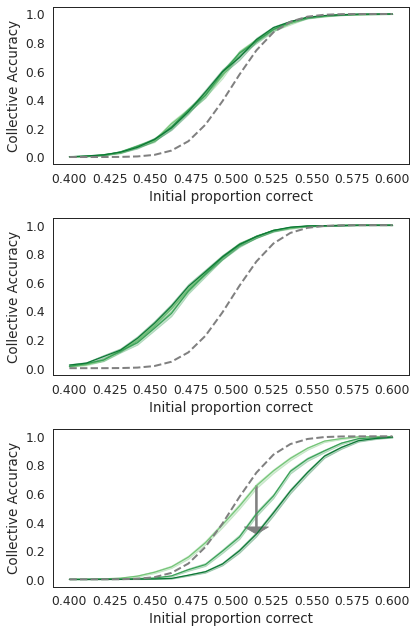

In [107]:
plt.figure(figsize=(6,9))
plt.subplot(311)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
plt.tight_layout()
plt.subplot(312)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])
plt.tight_layout()
plt.subplot(313)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])
plt.tight_layout()



<h1>Experiment 2</h1>

<h2>Model compilation and sampling</h2>

<h3>Prior Predictive Simulation</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

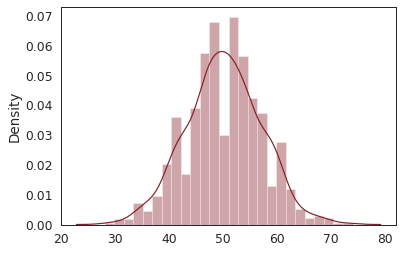

<Figure size 432x288 with 0 Axes>

In [108]:

alpha = np.random.normal(0,.2,1000);

y = np.random.binomial(100, ilogit(alpha));
sns.distplot(y)
plt.figure()


In [109]:

def format_stan_data_exp2(exp_2_data):
    false_exp2_data = exp_2_data[exp_2_data.answer==False]
    false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
    N = false_exp2_data.shape[0]
    p = 1*(false_exp2_data.p_recode.values)
    cond = false_exp2_data['cond_recode'].values+1
    y = 1*(false_exp2_data['social_correct'].values)
    false_exp2_data['cond_recode']
    pd.Categorical(false_exp2_data['cond_recode'])
    grouped_exp2 = false_exp2_data.groupby(['state', 'cond_recode', 'p_recode']).sum().reset_index()
    
    
    state_data = dict(y=grouped_exp2['social_correct'].astype('int').values,
                        N = grouped_exp2.shape[0],
                        count=grouped_exp2['count'].astype('int').values,
                        cond = grouped_exp2['p_recode'].values *3 + \
                           grouped_exp2['cond_recode'].astype('int').values+1)
    return state_data, false_exp2_data
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))

print(stan_data_exp2)
  

{'y': array([61, 45, 43, 53, 53, 50, 38, 42, 48, 35, 50, 40, 31, 51, 42, 53, 44,
       42, 54, 50, 40, 37, 52, 41, 48, 65, 49, 48, 40, 43, 49, 35, 36, 58,
       34, 46, 34, 47, 51, 45, 56, 43, 36, 56, 50, 60, 38, 37, 49, 58, 58,
       45, 50, 44, 40, 40, 46, 44, 56, 40]), 'N': 60, 'count': array([ 88,  82,  81,  80,  91,  86,  78,  74,  95,  86,  85,  77,  60,
        85,  84,  92,  74,  89,  88,  87,  81,  85,  84,  94,  78,  90,
        81,  85,  71,  74,  83,  68,  70,  80,  69,  85,  63,  98,  80,
        85,  83,  75,  68,  89,  86, 100,  71,  75,  83,  85,  90,  87,
        81,  72,  84,  80,  85,  84,  82,  75]), 'cond': array([1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5,
       3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4,
       2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6])}


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])


In [110]:
#from src.stan_data_format import format_stan_data_exp2
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
exp2_model = pystan.StanModel(file='./src/experiment_2_validation.stan')


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1440b0a435e2ad1856dabafc7c770426 NOW.


In [111]:
exp2_samples = exp2_model.sampling(data=stan_data_exp2)

<h2>Evaluate MCMC</h2

In [112]:
exp2_samples

Inference for Stan model: anon_model_1440b0a435e2ad1856dabafc7c770426.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   0.25  1.0e-3   0.07   0.11    0.2   0.25   0.29   0.38   4375    1.0
alpha[2]    0.2  9.6e-4   0.06   0.07   0.16    0.2   0.24   0.33   4574    1.0
alpha[3]   0.35  9.8e-4   0.07   0.21    0.3   0.35    0.4   0.49   4976    1.0
alpha[4]    0.3  9.2e-4   0.06   0.18   0.26    0.3   0.35   0.43   4958    1.0
alpha[5]   0.19  1.0e-3   0.07   0.06   0.15   0.19   0.24   0.32   4130    1.0
alpha[6]   0.11  1.0e-3   0.07  -0.02   0.06   0.11   0.16   0.24   4103    1.0
lp__      -3359    0.04   1.71  -3363  -3360  -3358  -3357  -3356   2234    1.0

Samples were drawn using NUTS at Sat Jan 30 12:47:03 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

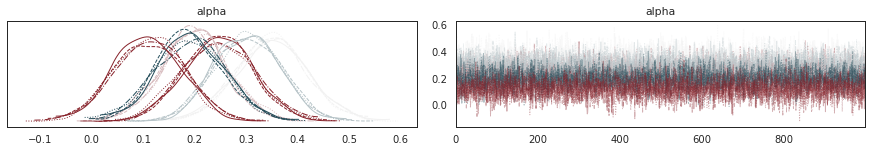

In [113]:
az.plot_trace(exp2_samples);

In [20]:
extracted_exp2 = exp2_samples.extract()


def plot_fig2F(exp2_samples):

    pal = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='dark')
    pal[1] = pal2[1]

    pal_order = [2,1,0]


    for idx in range(3):
        sns.kdeplot(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]),
                    shade=True, 
                    color=pal[pal_order[idx]])

    print(np.mean(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx])))
    print(np.percentile(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]), q=[5.5,94.5]))

    plt.xlabel('Impact of homophily\non accuracy')
    plt.ylabel('Density')

plot_fig2F(extracted_exp2)

NameError: name 'exp2_samples' is not defined

<h2>Coefficient Table</h2>

In [115]:
variables = ['logit_alpha']
extracted_exp2['logit_alpha'] = ilogit(extracted_exp2['alpha'])
latex_string = make_latex_table(extracted_exp2, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'experiment2.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 logit\_alpha &  0.561238 &  0.016879 &  0.533953 &  0.561337 &  0.588535 \\
 logit\_alpha &  0.549500 &  0.016001 &  0.522941 &  0.549728 &  0.575401 \\
 logit\_alpha &  0.586573 &  0.016744 &  0.559808 &  0.586825 &  0.613431 \\
 logit\_alpha &  0.574985 &  0.015728 &  0.549922 &  0.575076 &  0.599858 \\
 logit\_alpha &  0.547584 &  0.016477 &  0.521217 &  0.547296 &  0.573794 \\
 logit\_alpha &  0.527739 &  0.016649 &  0.501319 &  0.527805 &  0.554129 \\
\bottomrule
\end{tabular}



<h1>Figure 2</h1>

In [117]:


#plot_fig2E(exp2_data, exp2_samples)


In [118]:
from PIL import Image

def make_square(im, min_size=1000, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im



In [119]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()

Unnamed: 0    N  diff   lean    p           proportions  repeat  \
0           0  500   0.4  right  0.5  [75, 50, 30, 50, 75]       0   
1           1  500   0.4  right  0.5  [75, 50, 30, 50, 75]       1   
2           2  500   0.4  right  0.5  [75, 50, 30, 50, 75]       2   
3           3  500   0.4  right  0.5  [75, 50, 30, 50, 75]       3   
4           4  500   0.4  right  0.5  [75, 50, 30, 50, 75]       4   

   correct_final  correct_start  total  correct_majority  
0          0.438          0.438    1.0             False  
1          0.404          0.404    1.0             False  
2          0.444          0.444    1.0             False  
3          0.444          0.444    1.0             False  
4          0.454          0.454    1.0             False

0.5157894736842106
(20, 9)
0.586573223074372


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
<ipython-input-120-a85e41f771df>:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure2.pdf',dpi=1500, fmt='pdf')


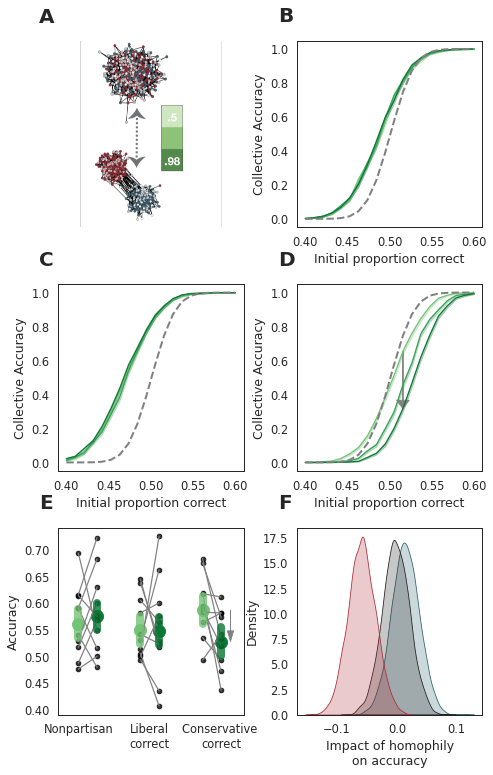

In [120]:
from src.exp_2_figures import plot_fig2E, plot_fig2F

sns.set_context('paper', font_scale=1.3)
plt.subplots(3,2,figsize=(7,10.5))


plt.subplot(322)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
ax = plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')


plt.subplot(321)
test_image = Image.open('./art/figure2A.png')
new_image = make_square(test_image)
plt.imshow(new_image)


ax = plt.gca()

ax.axis('off')
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')

plt.tight_layout()
plt.subplot(323)
ax = plt.gca()

ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])

plt.tight_layout()
plt.subplot(324)
ax = plt.gca()

ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])



plt.subplot(3,2,5)
ax = plt.gca()
ax.text(-0.1, 1.1, 'E', transform=ax.transAxes, 
        size=20, weight='bold')
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
plot_fig2E(exp2_data, exp2_samples)


plt.subplot(3,2,6)
ax = plt.gca()
ax.text(-0.1, 1.1, 'F', transform=ax.transAxes, 
        size=20, weight='bold')
plot_fig2F(exp2_samples)
plt.savefig(FIGURE_OUTPUT+'Figure2.pdf',dpi=1500, fmt='pdf')

<h1>Conceptual model</h1>

<h2>Define model and estimate parametrs from data</h3>

In [133]:

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

<ipython-input-146-d96b41d72935>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure3.pdf',dpi=1500, fmt='pdf')


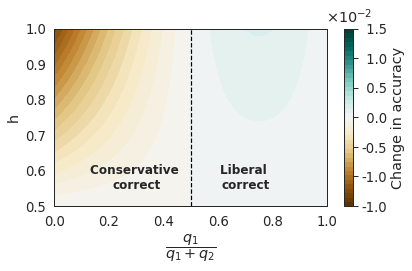

In [146]:
def get_prob(q1, q2, p, a11, g11, a22, g22, a21, g21, a12, g12):
    bb = p*(q1*(1-q1)*(a11-g11)) + (1-p) * (q2*a21*(1-q1)-g21*q1*(1-q2))

    cc = p*(q2*(1-q2)*(a22-g22)) + (1-p) * (q1*a12*(1-q2)-g12*q2*(1-q1))
    return (q1+q2+bb+cc)/2


#1=Libera
a11 = .25
g11 = .2
a12 = .2
g12 = .2

#2=Conservative
a22 = .2
g22 = .2
a21 = .25
g21 = .2



p = np.linspace(0.5, 1.0, 500)
q = np.linspace(0,1,500)

X, Y = np.meshgrid(q, p)
sns.set_context('paper', font_scale=1.5)
sns.set_palette(sns.diverging_palette(100, 280, s=85, l=25, n=20))

Z = get_prob(X, (1-X), Y, a11, g11, a22, g22, a21, g21, a12, g12) - \
    get_prob(X, (1-X), .5, a11, g11, a22, g22, a21, g21, a12, g12) 
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z*100,levels=np.linspace(-1.5, 1.5, 41),cmap=plt.get_cmap('BrBG'))
cb = fig.colorbar(cp,ticks=[-1.5,-1,-.5,0,.5,1.0,1.5]) # Add a colorbar to a plot
cb.ax.set_title(r'$\times 10^{-2}$')

cb.set_label('Change in accuracy')
cb.ax.set_yticklabels(['-1.0','-1.0','-0.5',' 0.0',' 0.5', ' 1.0', ' 1.5']) 
ax.set_xlabel('$\dfrac{q_1}{q_1+q_2}$')
ax.set_ylabel('h')
plt.plot([.5,.5], [.5,1], ls='--', color='k')
plt.tight_layout()

ax.text(0.3, .1, 'Conservative \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
ax.text(0.7, .1, 'Liberal \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
plt.savefig(FIGURE_OUTPUT+'Figure3.pdf',dpi=1500, fmt='pdf')

<h1>Experiment 3</h1>

<h2>Format data</h2>

In [2]:
EXPERIMENT_3 = './dat/raw/Experiment3.csv'
data, melted  = clean_exp3(pd.read_csv(EXPERIMENT_3))
melted.head()

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


conf  answer      question  correct  correct_conf  incorrect_conf  \
2  0.22    True  Russia_False    False      74.44898       82.278146   
3  0.88    True  Russia_False    False      74.44898       82.278146   
6  0.28   False  Russia_False     True      74.44898       82.278146   
7  0.92    True  Russia_False    False      74.44898       82.278146   
9  0.60    True  Russia_False    False      74.44898       82.278146   

   difficulty  pol_recode  DEM_1              DEM_2  ...       BSS WSS  EIS  \
2    0.393574           3  25-34            Liberal  ...  1.000000   3  1.4   
3    0.393574           0  25-34  Very Conservative  ...  2.333333   0  2.4   
6    0.393574           2  18-24           Moderate  ...  0.000000   1  2.0   
7    0.393574           1  55-64       Conservative  ...  1.333333   4  2.8   
9    0.393574           4  18-24       Very Liberal  ...  1.333333   4  0.8   

   HBS  NUMS  RIS                                CintID  edu_recode id_recode  \
2    4     3  2.0  28bed585-e303-9564-5492-e39545a3d55b           3        73   
3    2     0  1.6  11587f4b-61e3-301d-b25c-4973334bd79d           4        36   
6    0     1  2.0  f0319e12-096b-b176-db05-a81a1422bcc6           0       467   
7    2     3  2.0  811ae5ae-103d-a896-f0b9-d331c393a673           2       254   
9    2     3  1.2  7a542be2-4bf1-2fd3-bef5-1d7f0785fc36           2       235   

   question_code  
2             23  
3             23  
6             23  
7             23  
9             23  

[5 rows x 22 columns]

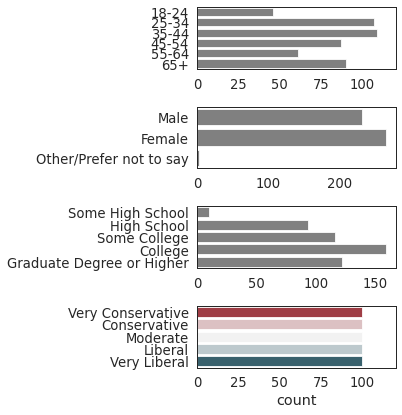

In [3]:
from src.exp_3_figures import plot_exp3_demographics
plot_exp3_demographics(data)
plt.savefig('./out/figures/Experiment3Demographics.pdf',transparent=True)


<h2>Load model</h2>

In [7]:
temp_model =  pystan.StanModel(file='./src/exp3_cchbm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_546428ea88b1ceed52bd3eafb395e0d1 NOW.


In [8]:
from src.stan_data_format import format_stan_data_exp3
exp3_stan_df = format_stan_data_exp3(melted)

<h3> Prior Predictive simulation</h3>

In [9]:
prior_samples = temp_model.sampling(data=exp3_stan_df, algorithm='Fixed_param')

(0.5, 1.0)

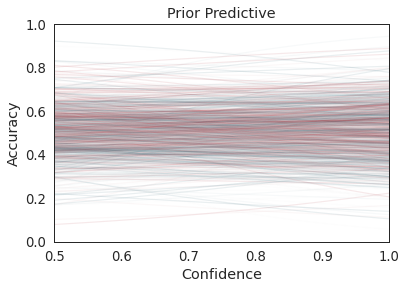

In [10]:
#Fit MLE estimates for regressions from the prior predictive. 
#It's a bit loose, but not out of line with what we saw in exp1, and we want 
#a lot of relationship flexibilty for questions and subjects. seems reasonable. 
from sklearn.linear_model import LogisticRegression
for idx in range(100):
    temp = melted.copy()
    chain = np.random.choice(4000)
    y_prior = prior_samples['y_prior'][chain,:]
    temp['y_prior'] = y_prior

    for idx in range(5):
        t = temp[temp['pol_recode']==idx]
        x = t['conf'].values

        clf = LogisticRegression(random_state=0).fit(x.reshape(-1, 1), t['y_prior'])

        xtemp = np.linspace(.5,1,100).reshape(-1, 1)
        ytemp = clf.predict_proba(xtemp)
        plt.plot(xtemp,ytemp,alpha=.1)
plt.title('Prior Predictive')
plt.xlabel("Confidence")
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.xlim(.5,1)

<h3>Sample model with political leaning for individual effects</h3>

In [11]:
exp3_model = pystan.StanModel(
    file='./src/exp3_cchbm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_546428ea88b1ceed52bd3eafb395e0d1 NOW.


In [12]:
from src.stan_data_format import format_stan_data_exp3
exp3_stan_df = format_stan_data_exp3(melted)

In [13]:
cchbml_samples = exp3_model.sampling(data=exp3_stan_df,)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scal

/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scal

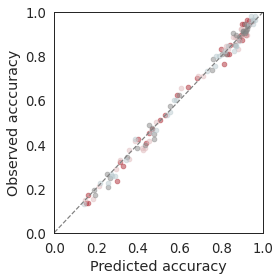

In [97]:
from src.exp_3_figures import plot_posterior_predictive_exp3
plot_posterior_predictive_exp3(melted, cchbml_samples)
plt.xlabel('Predicted accuracy')
plt.ylabel('Observed acccuracy')
plt.tight_layout()

plt.savefig('./out/figures/posterior_predictive_exp3.pdf')


In [14]:
az.summary(cchbml_samples, var_names=['alpha','beta','beta_q','gamma']).sort_values('r_hat',ascending=False)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha         0.352  0.597  -0.692    1.535      0.019    0.014     946.0   
beta          0.546  0.710  -0.792    1.868      0.022    0.016    1034.0   
gamma[1,3]    0.246  0.247  -0.209    0.707      0.008    0.006     973.0   
gamma[1,2]    0.207  0.245  -0.233    0.677      0.008    0.006     897.0   
gamma[1,1]    0.195  0.247  -0.252    0.667      0.008    0.005    1036.0   
...             ...    ...     ...      ...        ...      ...       ...   
beta_q[3,16] -0.076  0.306  -0.679    0.492      0.005    0.004    3160.0   
beta_q[3,15] -0.236  0.343  -0.894    0.403      0.006    0.005    2877.0   
beta_q[3,14] -0.148  0.385  -0.916    0.553      0.008    0.006    2248.0   
beta_q[3,13] -0.463  0.342  -1.075    0.145      0.006    0.004    3527.0   
beta_q[5,4]  -1.462  0.731  -2.947   -0.157      0.014    0.010    2924.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
alpha          946.0     946.0    1626.0   1.01  
beta          1034.0    1035.0    1603.0   1.01  
gamma[1,3]     973.0     965.0    1796.0   1.01  
gamma[1,2]     897.0     900.0    1858.0   1.01  
gamma[1,1]    1036.0    1038.0    1789.0   1.01  
...              ...       ...       ...    ...  
beta_q[3,16]  2824.0    3165.0    3190.0   1.00  
beta_q[3,15]  2877.0    2772.0    3486.0   1.00  
beta_q[3,14]  2248.0    2214.0    3195.0   1.00  
beta_q[3,13]  3527.0    3357.0    3053.0   1.00  
beta_q[5,4]   2694.0    2983.0    3209.0   1.00  

[332 rows x 11 columns]

In [15]:
az.summary(cchbml_samples,var_names=['beta_q','beta_s','gamma']).sort_values('r_hat',ascending=False).head()


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
gamma[1,4]     0.135  0.250  -0.332    0.594      0.008    0.005    1060.0   
beta_s[1,172]  0.253  0.259  -0.267    0.707      0.008    0.005    1125.0   
beta_s[1,159]  0.208  0.255  -0.262    0.699      0.008    0.006     974.0   
beta_s[1,160]  0.184  0.259  -0.300    0.682      0.009    0.006     907.0   
beta_s[1,161]  0.247  0.259  -0.252    0.717      0.008    0.005    1145.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
gamma[1,4]     1060.0    1054.0    1754.0   1.01  
beta_s[1,172]  1125.0    1120.0    2135.0   1.01  
beta_s[1,159]   974.0     977.0    1966.0   1.01  
beta_s[1,160]   907.0     912.0    1811.0   1.01  
beta_s[1,161]  1145.0    1145.0    1902.0   1.01

INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

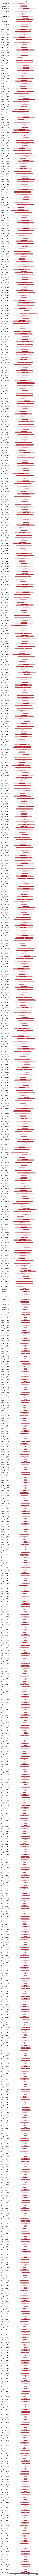

In [16]:
az.plot_forest(cchbml_samples,var_names=['beta_s'])


INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

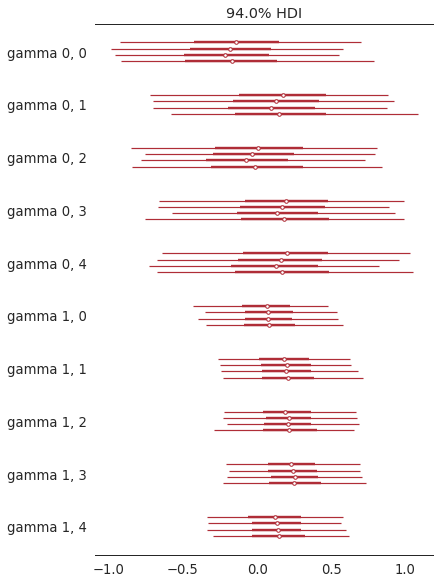

In [17]:
az.plot_forest(cchbml_samples,var_names=['gamma'])


In [18]:
az.summary(cchbml_samples,var_names=['L_Omega_q']).sort_values('r_hat',ascending=False)

/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: Runti

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
L_Omega_q[7,3]  0.300  0.217  -0.111    0.689      0.008    0.006     689.0   
L_Omega_q[8,3]  0.032  0.245  -0.423    0.496      0.009    0.006     787.0   
L_Omega_q[7,4]  0.093  0.223  -0.329    0.502      0.009    0.006     619.0   
L_Omega_q[9,6]  0.169  0.205  -0.187    0.586      0.006    0.004    1055.0   
L_Omega_q[6,3]  0.269  0.234  -0.177    0.683      0.008    0.006     767.0   
...               ...    ...     ...      ...        ...      ...       ...   
L_Omega_q[6,8]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[6,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[7,8]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[7,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   
L_Omega_q[8,9]  0.000  0.000   0.000    0.000      0.000    0.000    4000.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
L_Omega_q[7,3]   689.0     699.0    1445.0   1.01  
L_Omega_q[8,3]   787.0     790.0    1574.0   1.01  
L_Omega_q[7,4]   619.0     622.0    1234.0   1.01  
L_Omega_q[9,6]  1055.0    1059.0    2170.0   1.01  
L_Omega_q[6,3]   767.0     764.0    1454.0   1.01  
...                ...       ...       ...    ...  
L_Omega_q[6,8]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[6,9]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[7,8]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[7,9]  4000.0    4000.0    4000.0    NaN  
L_Omega_q[8,9]  4000.0    4000.0    4000.0    NaN  

[100 rows x 11 columns]

In [19]:
print("Effect of confidence (VC-VL)")
print(np.mean(cchbml_samples['gamma'][:,1,0] - cchbml_samples['gamma'][:,1,4]))

print("89% CI")
print(np.percentile(cchbml_samples['gamma'][:,1,0] - cchbml_samples['gamma'][:,1,4], q=[5.5,94.5]))

Effect of confidence (VC-VL)
-0.05864900395734355
89% CI
[-0.27711419  0.14859303]


In [20]:
az.summary(cchbml_samples,var_names=['qm']).sort_values('r_hat',ascending=False)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
qm[6,15] -0.040  0.851  -1.619    1.575      0.018    0.013    2257.0  2257.0   
qm[0,0]   0.706  0.774  -0.703    2.164      0.012    0.010    4512.0  2990.0   
qm[6,19] -0.931  0.860  -2.598    0.662      0.014    0.010    3768.0  3472.0   
qm[6,26]  0.616  0.873  -1.040    2.234      0.013    0.012    4813.0  2842.0   
qm[6,25]  0.294  0.830  -1.337    1.810      0.012    0.012    4588.0  2392.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
qm[3,9]   0.389  0.922  -1.334    2.133      0.019    0.014    2408.0  2315.0   
qm[3,8]   0.679  0.892  -1.064    2.245      0.017    0.012    2865.0  2865.0   
qm[3,7]  -0.159  0.790  -1.625    1.296      0.012    0.012    4537.0  2194.0   
qm[3,6]   0.061  0.801  -1.476    1.490      0.012    0.012    4301.0  2056.0   
qm[9,31] -0.170  0.890  -1.929    1.402      0.012    0.013    5570.0  2313.0   

          ess_bulk  ess_tail  r_hat  
qm[6,15]    2241.0    2980.0   1.01  
qm[0,0]     4516.0    3094.0   1.00  
qm[6,19]    3805.0    2984.0   1.00  
qm[6,26]    4821.0    3176.0   1.00  
qm[6,25]    4590.0    2998.0   1.00  
...            ...       ...    ...  
qm[3,9]     2419.0    2665.0   1.00  
qm[3,8]     2907.0    2561.0   1.00  
qm[3,7]     4558.0    3216.0   1.00  
qm[3,6]     4311.0    3033.0   1.00  
qm[9,31]    5583.0    3384.0   1.00  

[320 rows x 11 columns]

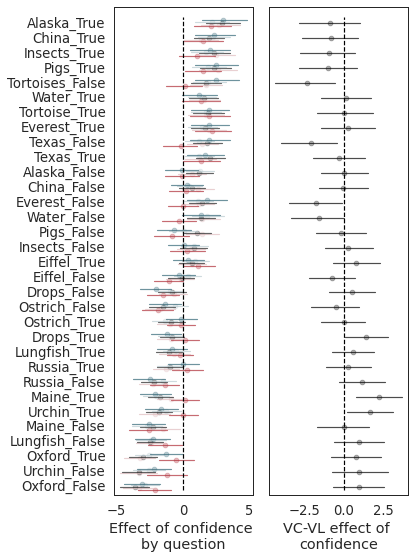

In [21]:
    
def plot_exp3_incidental(melted, samples):
    pal = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=5,l=40,center='dark')
    pal[2] = pal2[2]
    order = melted.groupby(['question_code']).mean()['correct'].argsort()

    q_names = []
    for item in melted.groupby(['question_code']):
        q_names.append(item[1]['question'][0])


    plt.figure(figsize=(6,8))

    plt.subplot(121)
    for yp,idx in enumerate(order):
        for jdx in range(5):
            temp = np.mean(samples['beta_q'][:,jdx+5,idx],axis=0)
            ci = np.percentile(samples['beta_q'][:,jdx+5,idx],q=[5.5,94.5])
            plt.scatter(temp,3*(yp+((jdx-3)*.1)),color=pal[jdx],alpha=.3)
            plt.plot([ci[0], ci[1]], [3*(yp+((jdx-3)*.1)),3*(yp+((jdx-3)*.1))],color=pal[jdx],alpha=.7)

    plt.yticks(np.arange(order.size)*3, np.array(q_names)[order])
    #plt.ylabel('alpha')
    plt.xlabel('Effect of confidence \nby question')
    plt.plot([0,0],[-1,3*np.max(order)+1],ls='--',color='k')
    plt.ylim(-2, 3*np.max(order)+3)

    plt.subplot(122)
    jdx = 2
    for yp,idx in enumerate(order):
        temp1 = samples['beta_q'][:,5,idx]
        temp2 = samples['beta_q'][:,-1,idx]
        ci = np.percentile(temp1-temp2,q=[5.5,94.5])
        plt.scatter(np.mean(temp1-temp2),3*(yp+((jdx-3)*.1)),color='k',alpha=.3)
        plt.plot([ci[0], ci[1]], [3*(yp+((jdx-3)*.1)),3*(yp+((jdx-3)*.1))],color='k',alpha=.7)

    #plt.yticks(np.arange(order.size)*3, np.array(q_names)[order])
    #plt.ylabel('alpha')
    plt.yticks([])
    plt.xlabel('VC-VL effect of \nconfidence')
    plt.plot([0,0],[-1,3*np.max(order)+1],ls='--',color='k')
    plt.ylim(-2, 3*np.max(order)+3)

plot_exp3_incidental(melted, cchbml_samples)
plt.tight_layout()
plt.savefig('./out/figures/figure4.pdf')

In [22]:
q=[5.5,50.0,94.5]
means = np.mean(cchbml_samples['gamma'][:,0,:],axis=0)
qs = np.percentile(cchbml_samples['gamma'][:,0,:],axis=0,q=[5.5,50.0,94.5])
sigma = np.std(cchbml_samples['gamma'][:,0,:],axis=0)
var=['$\\gamma_{0,'+idx+'}$' for idx in ['VC','C','M','L','VL']]

gamma_tx = pd.DataFrame({'Variable':var,
                         'Mean':means,
                          'sd':sigma, 
                         str(q[0]) + '%':qs[0],
                        str(q[1]) + '%':qs[1],
                        str(q[2]) + '%':qs[2]})
q=[5.5,50.0,94.5]
means = np.mean(cchbml_samples['gamma'][:,1,:],axis=0)
qs = np.percentile(cchbml_samples['gamma'][:,1,:],axis=0,q=[5.5,50.0,94.5])
sigma = np.std(cchbml_samples['gamma'][:,1,:],axis=0)
var=['$\gamma_{1,'+idx+'}$' for idx in ['VC','C','M','L','VL']]


gamma_tx2 = pd.DataFrame({'Variable':var,
                         'Mean':means,
                          'sd':sigma, 
                         str(q[0]) + '%':qs[0],
                        str(q[1]) + '%':qs[1],
                        str(q[2]) + '%':qs[2]})

pd.concat([gamma_tx, gamma_tx2]).to_latex('./out/tables/Exp3GammaModel1.tex',index=False,escape=False)

gamma_tx2

Variable      Mean        sd      5.5%     50.0%     94.5%
0  $\gamma_{1,VC}$  0.076405  0.244912 -0.307997  0.074291  0.470711
1   $\gamma_{1,C}$  0.195357  0.247008 -0.187244  0.196314  0.590471
2   $\gamma_{1,M}$  0.207181  0.244872 -0.188556  0.205757  0.600126
3   $\gamma_{1,L}$  0.245809  0.246686 -0.142913  0.247441  0.645515
4  $\gamma_{1,VL}$  0.135054  0.249939 -0.254895  0.135959  0.536314

In [26]:
q=[5.5,50.0,94.5]
means = np.mean(np.mean(cchbml_samples['beta_q'][:,0:5,:],axis=0),axis=0)
qs = np.percentile(cchbml_samples['beta_q'][0,0:5,:],axis=0,q=[5.5,50.0,94.5])
qs[0].shape
questions = melted.groupby('question').mean().reset_index().sort_values('question_code')['question']


effects = np.mean(np.mean(cchbml_samples['beta_q'][:,5:,:],axis=0),axis=0)
effect_qs = np.percentile(cchbml_samples['beta_q'][0,5:,:],axis=0,q=[5.5,50.0,94.5])



df1 = pd.DataFrame({'Question':questions.values,'$B_\text{q,INTCP}$':means,
     str(q[0]) + '%':qs[0],
    str(q[1]) + '%':qs[1],
    str(q[2]) + '%':qs[2],
    '$B_\text{q,CONF}$':effects,
    str(q[0]) + '% ':effect_qs[0],
    str(q[1]) + '% ':effect_qs[1],
    str(q[2]) + '% ':effect_qs[2]})

df1.to_latex('./out/tables/questions_posterior.tex',index=False)


<h2>Analysis of cognitive battery</h2>

In [61]:
exp3_stan_df_cb = format_stan_data_exp3(melted,with_cb=True)

In [62]:
cbsamples = exp3_model.sampling(data=exp3_stan_df_cb)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [63]:
az.summary(cbsamples, var_names=['alpha','beta','beta_q','gamma']).sort_values('r_hat',ascending=False)





mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha         0.002  0.088  -0.155    0.176      0.001    0.001    3480.0   
beta_q[7,3]   2.066  0.694   0.578    3.253      0.011    0.008    3772.0   
beta_q[7,1]   3.017  0.800   1.569    4.548      0.014    0.010    3469.0   
beta_q[7,0]   1.300  0.642   0.075    2.498      0.010    0.007    4172.0   
beta_q[6,31]  1.808  0.697   0.557    3.219      0.011    0.008    3737.0   
...             ...    ...     ...      ...        ...      ...       ...   
beta_q[3,12] -0.461  0.352  -1.100    0.157      0.007    0.005    2895.0   
beta_q[3,11]  0.285  0.384  -0.408    1.025      0.007    0.005    3476.0   
beta_q[3,10]  0.406  0.373  -0.231    1.139      0.006    0.005    3853.0   
beta_q[3,9]   0.171  0.352  -0.487    0.867      0.006    0.004    3069.0   
gamma[1,5]    0.007  0.031  -0.045    0.071      0.000    0.000    7189.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
alpha         3111.0    3486.0    3388.0    1.0  
beta_q[7,3]   3772.0    3764.0    3883.0    1.0  
beta_q[7,1]   3323.0    3536.0    3406.0    1.0  
beta_q[7,0]   3798.0    4160.0    3634.0    1.0  
beta_q[6,31]  3737.0    3731.0    3812.0    1.0  
...              ...       ...       ...    ...  
beta_q[3,12]  2895.0    2840.0    3196.0    1.0  
beta_q[3,11]  3142.0    3357.0    3139.0    1.0  
beta_q[3,10]  3390.0    3915.0    3310.0    1.0  
beta_q[3,9]   3069.0    2975.0    3273.0    1.0  
gamma[1,5]    2289.0    7211.0    3157.0    1.0  

[334 rows x 11 columns]

In [64]:
az.summary(cbsamples,var_names=['beta_q','beta_s','gamma']).sort_values('r_hat',ascending=False).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta_s[0,138] -0.180  0.184  -0.521    0.183      0.002    0.002    7851.0   
beta_s[1,490]  0.050  0.093  -0.138    0.213      0.001    0.001    5025.0   
beta_s[1,55]   0.274  0.109   0.066    0.472      0.001    0.001    6600.0   
beta_s[1,65]  -0.295  0.110  -0.502   -0.094      0.002    0.001    4737.0   
beta_s[1,72]   0.146  0.110  -0.063    0.348      0.002    0.001    4790.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
beta_s[0,138]  2755.0    7927.0    2804.0   1.01  
beta_s[1,490]  2943.0    5026.0    3240.0   1.01  
beta_s[1,55]   5538.0    6543.0    3452.0   1.00  
beta_s[1,65]   4099.0    4829.0    3348.0   1.00  
beta_s[1,72]   3565.0    4934.0    3108.0   1.00

INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

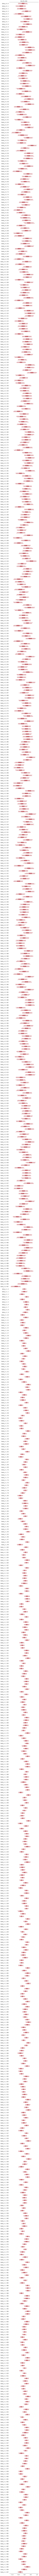

In [65]:
az.plot_forest(cbsamples,var_names=['beta_s'])

INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

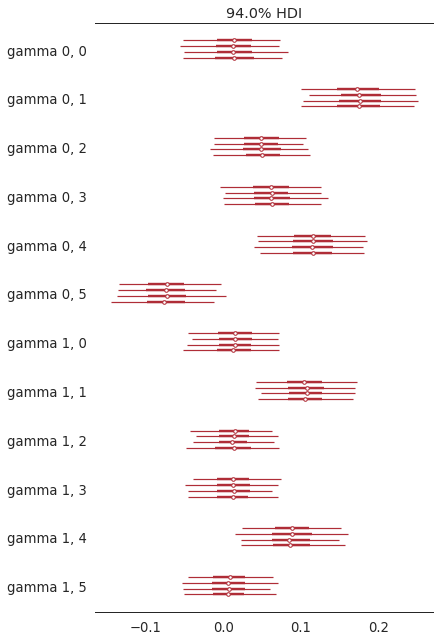

In [66]:
az.plot_forest(cbsamples,var_names=['gamma'])

In [67]:
question_codes = pd.read_csv('./dat/Exp3questions.csv',names=['Code', 'Text'])
question_codes.sort_values('Code').to_latex('./out/tables/exp3Questions.tex',index=False)



In [68]:
q=[5.5,50.0,94.5]
means = np.mean(np.mean(cbsamples['beta_q'][:,0:5,:],axis=0),axis=0)
qs = np.percentile(cbsamples['beta_q'][0,0:5,:],axis=0,q=[5.5,50.0,94.5])
qs[0].shape
questions = melted.groupby('question').mean().reset_index().sort_values('question_code')['question']


effects = np.mean(np.mean(cbsamples['beta_q'][:,5:,:],axis=0),axis=0)
effect_qs = np.percentile(cbsamples['beta_q'][0,5:,:],axis=0,q=[5.5,50.0,94.5])



df1 = pd.DataFrame({'Question':questions.values,'$B_\text{q,INTCP}$':means,
     str(q[0]) + '%':qs[0],
    str(q[1]) + '%':qs[1],
    str(q[2]) + '%':qs[2],
    '$B_\text{q,CONF}$':effects,
    str(q[0]) + '% ':effect_qs[0],
    str(q[1]) + '% ':effect_qs[1],
    str(q[2]) + '% ':effect_qs[2]})




In [69]:
az.summary(cbsamples,var_names=['gamma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
gamma[0,0]  0.014  0.034  -0.051    0.077      0.000      0.0    5311.0   
gamma[0,1]  0.175  0.039   0.105    0.249      0.001      0.0    5695.0   
gamma[0,2]  0.049  0.033  -0.012    0.109      0.000      0.0    8012.0   
gamma[0,3]  0.062  0.034  -0.003    0.125      0.000      0.0    6611.0   
gamma[0,4]  0.115  0.037   0.046    0.185      0.000      0.0    6403.0   
gamma[0,5] -0.074  0.036  -0.144   -0.011      0.000      0.0    7458.0   
gamma[1,0]  0.015  0.032  -0.046    0.072      0.000      0.0    6663.0   
gamma[1,1]  0.106  0.033   0.042    0.167      0.000      0.0    6752.0   
gamma[1,2]  0.013  0.029  -0.040    0.070      0.000      0.0    7284.0   
gamma[1,3]  0.013  0.031  -0.043    0.071      0.000      0.0    5674.0   
gamma[1,4]  0.087  0.036   0.021    0.156      0.000      0.0    6877.0   
gamma[1,5]  0.007  0.031  -0.045    0.071      0.000      0.0    7189.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
gamma[0,0]  2633.0    5331.0    3253.0    1.0  
gamma[0,1]  5360.0    5712.0    2931.0    1.0  
gamma[0,2]  4483.0    7946.0    3080.0    1.0  
gamma[0,3]  5695.0    6590.0    3399.0    1.0  
gamma[0,4]  5908.0    6414.0    3290.0    1.0  
gamma[0,5]  5705.0    7485.0    3373.0    1.0  
gamma[1,0]  2529.0    6673.0    3233.0    1.0  
gamma[1,1]  6081.0    6749.0    3541.0    1.0  
gamma[1,2]  2299.0    7292.0    3114.0    1.0  
gamma[1,3]  2720.0    5677.0    3127.0    1.0  
gamma[1,4]  6025.0    6892.0    3094.0    1.0  
gamma[1,5]  2289.0    7211.0    3157.0    1.0

In [84]:
q=[5.5,50.0,94.5]
means = np.hstack([np.mean(cbsamples['gamma'][:,0,:],axis=0),
                  np.mean(cbsamples['gamma'][:,1,:],axis=0)])
sd = np.hstack([np.std(cbsamples['gamma'][:,0,:],axis=0),
                  np.std(cbsamples['gamma'][:,1,:],axis=0)])

cis = np.hstack([np.percentile(cbsamples['gamma'][:,0,:],axis=0,q=q),
                  np.percentile(cbsamples['gamma'][:,1,:],axis=0,q=q)])
names = ['Bullshit Sensitivity','Wordsums',
         'Need for Cognition','Heuristics and Biases','Numeracy','Faith in Intuition']



df_cb = pd.DataFrame({'Trait':names + names,
                     'Variable':np.hstack([np.repeat('Intcp',6), np.repeat('Conf',6)]),
    'Mean':means,
    'sd':sd,
     str(q[0]) + '%':cis[0],
     str(q[1]) + '%':cis[1],
     str(q[2]) + '%':cis[2]})
df_cb.to_latex('./out/tables/cb.tex',index=False)
df_cb

Trait Variable      Mean        sd      5.5%     50.0%  \
0    Bullshit Sensitivity    Intcp  0.013585  0.034412 -0.042719  0.013417   
1                Wordsums    Intcp  0.175036  0.039285  0.112603  0.173970   
2      Need for Cognition    Intcp  0.048885  0.033140 -0.004315  0.048673   
3   Heuristics and Biases    Intcp  0.062304  0.034199  0.006629  0.062055   
4                Numeracy    Intcp  0.115119  0.037236  0.054793  0.115361   
5      Faith in Intuition    Intcp -0.073719  0.035692 -0.131025 -0.073713   
6    Bullshit Sensitivity     Conf  0.015036  0.031818 -0.035181  0.014565   
7                Wordsums     Conf  0.105578  0.033495  0.051558  0.105874   
8      Need for Cognition     Conf  0.013235  0.029234 -0.032969  0.013134   
9   Heuristics and Biases     Conf  0.013057  0.030578 -0.036212  0.013309   
10               Numeracy     Conf  0.087389  0.035789  0.028862  0.086877   
11     Faith in Intuition     Conf  0.007178  0.030673 -0.040579  0.006885   

       94.5%  
0   0.067683  
1   0.239074  
2   0.100403  
3   0.117379  
4   0.174759  
5  -0.016723  
6   0.065225  
7   0.160185  
8   0.059742  
9   0.062103  
10  0.143803  
11  0.056909

array(['Intcpt', 'Intcpt', 'Intcpt', 'Intcpt', 'Intcpt', 'Conf', 'Conf',
       'Conf', 'Conf', 'Conf'], dtype='<U6')

In [71]:
az.summary(cbsamples,var_names=['qm']).sort_values('r_hat',ascending=False)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
qm[0,0]   0.856  0.767  -0.611    2.250      0.011    0.009    5011.0  3605.0   
qm[0,1]   0.302  0.747  -0.985    1.749      0.012    0.012    3800.0  1922.0   
qm[6,26]  0.793  0.837  -0.777    2.327      0.012    0.010    5224.0  3336.0   
qm[6,25]  0.461  0.815  -1.175    1.897      0.012    0.011    4440.0  2612.0   
qm[6,24]  0.329  0.818  -1.208    1.871      0.013    0.011    4044.0  2600.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
qm[3,9]   0.418  0.910  -1.399    2.025      0.018    0.013    2545.0  2545.0   
qm[3,8]   0.651  0.925  -1.140    2.319      0.016    0.012    3440.0  2903.0   
qm[3,7]  -0.106  0.809  -1.615    1.380      0.012    0.011    4686.0  2696.0   
qm[3,6]   0.129  0.820  -1.495    1.604      0.012    0.012    5046.0  2443.0   
qm[9,31] -0.151  0.859  -1.718    1.472      0.010    0.013    7700.0  2047.0   

          ess_bulk  ess_tail  r_hat  
qm[0,0]     5012.0    3677.0    1.0  
qm[0,1]     3777.0    2850.0    1.0  
qm[6,26]    5226.0    3263.0    1.0  
qm[6,25]    4431.0    3098.0    1.0  
qm[6,24]    4054.0    3244.0    1.0  
...            ...       ...    ...  
qm[3,9]     2545.0    3261.0    1.0  
qm[3,8]     3455.0    3273.0    1.0  
qm[3,7]     4688.0    3364.0    1.0  
qm[3,6]     5047.0    3426.0    1.0  
qm[9,31]    7693.0    3243.0    1.0  

[320 rows x 11 columns]